## Homework 09

#### *08 November 2019*
#### *DATA 1010*

## Problem 1

In this problem, we'll explore the reason *gradient boosting* has the word *gradient* in its name. The story is compelling as well as practical, because it leads to a generalization of the boosting method which works for loss functions other than mean squared error. The main idea is that gradient boosting can be thought of as **applying gradient descent to the *model***. It will take several steps to unpack this clever idea. 

**Step 1**: Consider a very simple learning setup where $\mathcal{X} = \{1,2,\ldots,10\}$ and $\mathcal{Y} = \mathbb{R}$. We'll consider a totally flexible model which makes a different prediction for every element of $\mathcal{X}$, with no constraints on how those predictions relate to each other. In other words, any element $\mathbf{\hat{y}} = (\hat{y}_1, \hat{y}_2, \ldots, \hat{y}_{10})$ of $\mathbb{R}^{10}$ will be considered a valid model. As a loss functional, we'll use mean squared error. 

Suppose that we happen to get 10 training observations, one for each value of $\mathcal{X}$. What is the empirical loss minimizer? 

In [8]:
import Pkg
Pkg.add("Polynomials")

 Resolving package versions...
  Updating `~/.julia/environments/v1.2/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.2/Manifest.toml`
 [no changes]


In [9]:
import Pkg; Pkg.add("Statistics")
using Test, Plots, LaTeXStrings, Polynomials, Statistics

 Resolving package versions...
  Updating `~/.julia/environments/v1.2/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.2/Manifest.toml`
 [no changes]


In [3]:
pyplot(fontfamily = "Palatino", size = (400, 250), fmt = :svg);

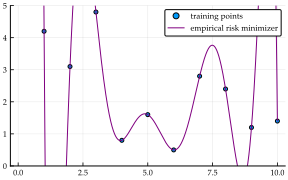

In [4]:
x = 1:10
y = [4.2, 3.1, 4.8, 0.8, 1.6, 0.5, 2.8, 2.4, 1.2, 1.4]
scatter(x,y, ylims = (0,5), label = "training points")

p = polyfit(x,y)
plot!(0:0.01:10, x->p(x), label = "empirical risk minimizer", color = :purple)


Proposal: The empirical risk minimizer is the function which minimizes the mean squared error. An example of such a function would be the polynomial of degree 10 that passes through all of the observations.

**Step 2**: Now, let's pretend we didn't notice how to cut straight to the empirical risk minimizer, as we did in Step 1. Let's suppose we start with some random initial guess for $\mathbf{\hat{y}}$ (shown below) and want to move closer to the correct solution using gradient descent. Note that this *is* grad descent with no bells and whistles, since the function we're minimizing is a function of the 10 variables $\hat{y}_1, \ldots, \hat{y}_{10}$. 

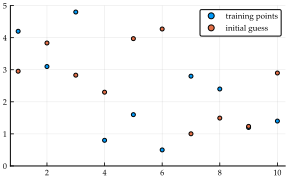

In [5]:
using Random; 
function training_plot()
    scatter(x, y, ylims = (0,5), label = "training points")
end
function random_start_plot!()
    Random.seed!(1234)
    ŷ = 5rand(10)
    scatter!(x, ŷ, ylims = (0,5), label = "initial guess")
end
training_plot()
random_start_plot!()

Make a plot which looks like the one below, which shows convergence of the gradient descent algorithm with learning rate 0.5. 

<img src="grad-descent-convergence.svg">

Note: if we had used a learning rate of 1.0, we would actually skip directly to the optimizing value in a single step. More on that later.

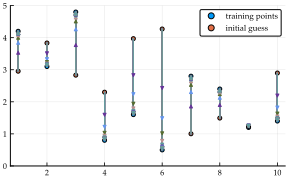

In [7]:
function grad_descent_plot()
    Random.seed!(1234)
    ŷ = 5rand(10)
    training_plot()
    random_start_plot!()
    ŷ_prev = ŷ_new = ŷ
    for i in 1:5, acolor in [:rebeccapurple, :cornflowerblue, :darkolivegreen, :rosybrown, :cadetblue] #color = :rebeccapurple
        # perform grad descent update with learning rate 0.5
        # We want to move in the direction that will decrease the distance to the actual observation the fastest  
        ŷ_new = ŷ_new + 0.5(y-ŷ_new) #the derivative of (y - y^)^2 = 2(y - y^)(dy^/dy^) =2(y - y^)
        
        for j in 1:10
            # draw arrows
            plot!([(x[j], ŷ_prev[j]), (x[j], ŷ_new[j])], arrow = arrow(), color = acolor, lw = 1, label = "")
        end
    end
    current()
end
grad_descent_plot()

**Step 3**. There are several problems with using a unconstrained model (for example, it's prone to overfitting, and it isn't generalizable to settings where $\mathcal{X}$ is not discrete). We'd like to introduce some inductive bias by taking each step (which comprises *10* changes, one for each component of $\mathbf{\hat{y}}$) according to a more restrictive model. For example, we can use a depth-1 decision tree (also called a **decision stump**). While we're at it, let's also choose the starting point by fitting a model to the original data, rather than choosing the initial point randomly. 

Complete the definitions of the functions in the following cell and run the cell following that one to visualize the training process wherein each desired gradient step is approximated with a decision tree rather than being taken directly. 

In [27]:
"""
Return the vector obtained by replacing the first 
k values with their average and the remaining values
with their average
"""

function decision_stump_fit(y, k)
    return vcat([mean(y[1:k]) for _ in 1:k], [mean(y[k+1:end]) for _ in k+1:length(y)]) 
end


@test decision_stump_fit([2, 2, 5, 5, 5], 3) ≈ [3, 3, 3, 5, 5]


"""
Return the best decision stump fit, by mean squared error
"""


#=
* For each possible split k, the function which minimizes 
the mean squared error is that which, for each of the two k-partitions, 
is piecewise constant at the mean of (the response values of) 
the data points at that partition. (since the mean of the response values
minimizes the mean squared error for that partition). 

* And the function (in code) above, decision_stump_fit(y, k), 
in effect gives us the pointwise MSE-minimizing function for each k.

* So, to find the split k_min which minmizes MSE the most,
we can 

1. 
a. Call  decision_stump_fit(y, k) for each possible value of k; collect that into a list. 
b. record the total MSE for each such fit
c. find the k which min total MSE the most; return the k-th index of listYHats

=#
function decision_stump_fit(y)
    mse(ŷ) = sum((y - ŷ).^2) # def ftn mse
    
    listYHats = [decision_stump_fit(y, k) for k in 1:length(y)] #1a
    min_value, min_index = findmin([mse(y_hat) for y_hat in listYHats])
    return listYHats[min_index]
    
end

@test decision_stump_fit([1, 2, 1, 5, 5]) ≈ [4/3, 4/3, 4/3, 5, 5]


Test Passed

In the plot below, we'll make double use of the horizontal axis, so that the arrows indicating iterations are easier to read. Bear in mind that **each connected sequence of arrows pertain to the same $x$ value.** 

(Note to self: don't forget also that we're dealing with depth = 1 trees, and each split is binary)

Infer *from the graph* where each of the six decision trees made its split. 

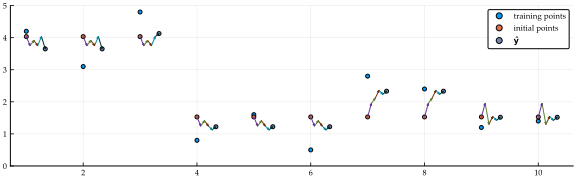

In [25]:
function grad_descent_decision_tree_plot(num_iterations)
    training_plot()
    colors = Plots.Colors.distinguishable_colors(num_iterations, colorant"rebeccapurple", 
                                                 lchoices = 15:50, cchoices = 15:50)
    ŷ_prev = ŷ_new = decision_stump_fit(y)
    scatter!(1:10, ŷ_new, label = "initial points")
    for i in 1:num_iterations
        ŷ_prev = ŷ_new
        ŷ_new += decision_stump_fit(y - ŷ_new)
        for j in 1:10
            plot!([(j + (i-1)/(3*num_iterations), ŷ_prev[j]), 
                   (j + i/(3*num_iterations), ŷ_new[j])], arrow = arrow(:closed, 0.2, 0.15), 
                    color = colors[i], lw = 1, msw = 0, label = "")
        end
    end
    scatter!((1:10) .+ 1/3, ŷ_new, label = L"$\mathbf{\hat{y}}$", size = (800,250))
    current()
end
grad_descent_decision_tree_plot(5)


*Solution*. From inspecting the graph (and looking at where the arrows change direction), the splits are at x=:
1. 4
2. 7 
3. 9
4. 4
5. 3

---

**Step 4**. Steps 1 through 3 above establish the connection between gradient descent and gradient boosting (since Step 3 *is* a boosted decision tree!). There is one loose end to tie up: why does gradient descent involve a learning rate, while gradient boosting does not? 

The answer is actually that gradient boosting *does* involve a learning rate. It's just that there's an especially natural choice of learning rate (namely, 1) when we're dealing with the mean squared error loss. This is a special case of a gradient descent variant called *Newton's method* which requires an estimate of the second-order derivative of the objective function: 

(a) Suppose that $f$ is a differentiable function we're trying to minimize, and suppose that $\mathbf{x}_k$ is a guess for the minimum. Show that if we differentiate $f(\mathbf{x}_k) + \nabla f(\mathbf{x}_k)(\mathbf{x}-\mathbf{x}_k) + \frac{1}{2}(\mathbf{x}-\mathbf{x}_k)'H(\mathbf{x}_k)(\mathbf{x}-\mathbf{x}_k)$ with respect to $\mathbf{x}$ and set the result equal to zero (since we are looking for a critical point of $f$), then we find $\mathbf{x} = \mathbf{x}_k - [H(\mathbf{x}_k)]^{-1}\nabla f(\mathbf{x}_k)$. This suggests the update rule
$$
\mathbf{x}_{k+1} = \mathbf{x}_k - [H(\mathbf{x}_k)]^{-1}\nabla f(\mathbf{x}_k).
$$

(b) Show further the Hessian $H$ is the identity matrix if $f$ is one-half times a mean squared error loss function (that is, a function of the form $f(\mathbf{x}) = \frac{1}{2}(\mathbf{x} - \mathbf{u})'(\mathbf{x} - \mathbf{u})$, where $\mathbf{u}$ is a vector (corresponding to the training response values)). Show that the Newton update rule is the same in this case as using plain vanilla gradient descent with a learning rate of $1$. 

*Solution*. 

---

## Problem 2

Armed with a gradient boosting perspective that generalizes the fit-the-residuals idea we began with, we can apply the idea in more general settings. Apply gradient boosting with logistic loss to estimate the regression function for the binary classification problem shown below. Feel free to use the constant function 1/2 as the initial model. 

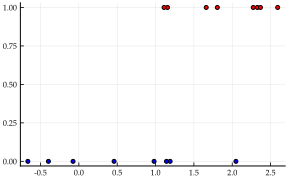

In [28]:
n = 8
Random.seed!(123)
blues = randn(n)
reds = 2 .+ randn(n)
xs = [blues; reds]
ys = repeat([0,1], inner = n)
function logistic_training_points()
    scatter([(p,0) for p in blues], color = :blue, legend = false)
    scatter!([(p,1) for p in reds], color = :red)
end
logistic_training_points()

Find the derivative of the logistic loss with respect to the vector `rs` of predictions at the training points. This is called the *pseudoresidual*, and it's the vector we'll be fitting each model with.

In [46]:
# fill out the ternary conditional in the array comprehension:
#= 
return 
 * diff(lg 1 / r_i)= r_i if it's class 1 
 * diff(lg 1 / 1-r_i)=1-r_i if it's class 0

=#


pseudoresidual(rs, ys) = [ (y==1 ? r : 1 - r) for (r,y) in zip(rs, ys)]

pseudoresidual (generic function with 1 method)

In [47]:
rs = fill(1/2, 2n); # start with an estimate of 1/2 for every point

Now you can execute this cell repeatedly to fit the pseudoresiduals with a decision stump and perform an update of the estimate vector `rs`. 

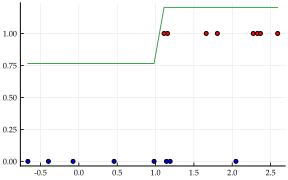

In [68]:
# we're using a small learning rate:
rs .+= 0.05decision_stump_fit([y for (x,y) in 
            sort(collect(zip(xs, pseudoresidual(rs, ys))), by = first)])
logistic_training_points()
plot!(sort(xs), rs)

You should find that the model eventually misbehaves, because the probability estimates go past 0 and/or 1. What could we have done to avoid this problem of overshooting 0 and 1?

*Proposal:* Use a smaller learning rate.

---

## Problem 3

Read the first three sections of the [Wikipedia article on Random Forests](https://en.wikipedia.org/wiki/Random_forest). Comment on the assertion *random forests are just bagged decision trees*. 

*Solution*. Random forests differ from bagged decision trees in one way: whereas any feature is eligible for splitting in bagged decision trees, only a random subset of the features would be eligible for splitting for random forests.

---

## Problem 4

It is not useful to apply bagging or boosting to linear regression models. Why not? 

*Solution*. 

---

## Problem 5

Suppose that weights and biases have been chosen for the neural network shown, and that a vector has been forward propagated through the network. Suppose that the vectors recorded at the purple nodes are $[1, -4, 2]$, $[6, 3]$, and $[9, 7, -4, -1, 5]$.

<center>
    <img src="neural-net.svg">
</center>

<p></p>

i) What vector is recorded at the second green node (the one between $A_1$ and $A_2$)?

ii) Now suppose that we are in the midst of the backpropagation process, and we have just determined that the derivative of the cost with respect to the vector in the second purple node is equal to $[-3,-4]'$.  Calculate the derivative of the cost with respect to the matrix $W_2$. 


*Solution*. 

In [0]:
i) 

In [ ]:
ii) 